#### Esercitazione sulle Self Organizing Map (SOM).
##### Le SOM sono un algoritmo di apprendimento non supervisionato introdotto da Teuvo Kohonen nel 1980. La Map organizza se stesso senza nessuna istruzione ricevuta in input. La sua architettura e' la seguente: e' costituito da un insieme di neuroni disposti su una griglia bidimensionale; ogni neurone ha un insieme di coordinate che specificano la sua posizione all'interno della griglia. Non ci sono connessioni tra neuroni nella griglia. Tutti i neuroni ricevono un vettore di input x di dimensione n e ogni neurone ha un suo vettore pesi w associato. Viene calcolata l'attivazione di un neurone in risposta ad un certo input x e il neurone vincitore viene definito Best Matching Unit (BMU) e rappresenta il neurone con il piu alto livello di attivazione. Una volta calcolata la BMU, trovo i neuroni piu vicini al neurono BMU tramite la funzione di neighborhood; sucessivamente aggiorno i pesi della BMU e dei suoi vicini. Se il conteggio massimo delle iterazioni di training e' raggiunto esco dall'algoritmo, altrimento continuo con l'aggiornamento dei pesi.

In [573]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from matplotlib import patches as patches

In [574]:
#Import Dataset

df = pd.read_csv('iris.txt')
df.head()

df = df.iloc[:,:-1]
df.dtypes

sepal length    float64
sepal width     float64
petal length    float64
petal width     float64
dtype: object

In [575]:
feature_scaler = MinMaxScaler(feature_range=(0, 1)) #faccio rientrare le mie feature in un range tra 0, 1 --> normalizzazione
df_scaled = feature_scaler.fit_transform(df) #fitto i parametri
df_scaled = pd.DataFrame(data=df_scaled)
df_scaled.head()

,0,1,2,3
0,0.222222,0.625000,0.067797,0.041667
1,0.166667,0.416667,0.067797,0.041667
2,0.111111,0.500000,0.050847,0.041667
3,0.083333,0.458333,0.084746,0.041667
4,0.194444,0.666667,0.067797,0.041667


In [576]:
#definisco gli iperparametri per SOM
num_col = 8
num_rows = 8
epoch = 5000
learning_rate = 0.01
np.random.seed(10)

In [577]:
rows, col = df_scaled.shape
print("Data count = %d rows and column count = %d" %(rows,col))

Data count = 150 rows and column count = 4


In [578]:
#settp i valori della mia funzione di neighborhood
initial_radius = max(num_col, num_rows)/2  #ampiezza della gaussiana
time_constant = epoch/np.log(initial_radius) # teta value

In [579]:
#inizio a costruire la SOM impostando il vettore pesi iniziali per ogni neurone.
som_net = np.random.random((num_rows, num_col, col)) #inizio impostando dei pesi random alla mia SOM
print("Vettore Pesi iniziale della SOM : ")
print(som_net)

Vettore Pesi iniziale della SOM : 
[[[0.77132064 0.02075195 0.63364823 0.74880388]
  [0.49850701 0.22479665 0.19806286 0.76053071]
  [0.16911084 0.08833981 0.68535982 0.95339335]
  [0.00394827 0.51219226 0.81262096 0.61252607]
  [0.72175532 0.29187607 0.91777412 0.71457578]
  [0.54254437 0.14217005 0.37334076 0.67413362]
  [0.44183317 0.43401399 0.61776698 0.51313824]
  [0.65039718 0.60103895 0.8052232  0.52164715]]

 [[0.90864888 0.31923609 0.09045935 0.30070006]
  [0.11398436 0.82868133 0.04689632 0.62628715]
  [0.54758616 0.819287   0.19894754 0.8568503 ]
  [0.35165264 0.75464769 0.29596171 0.88393648]
  [0.32551164 0.1650159  0.39252924 0.09346037]
  [0.82110566 0.15115202 0.38411445 0.94426071]
  [0.98762547 0.45630455 0.82612284 0.25137413]
  [0.59737165 0.90283176 0.53455795 0.59020136]]

 [[0.03928177 0.35718176 0.07961309 0.30545992]
  [0.33071931 0.7738303  0.03995921 0.42949218]
  [0.31492687 0.63649114 0.34634715 0.04309736]
  [0.87991517 0.76324059 0.87809664 0.41750914]
 

In [580]:
#Definisco una funzione per il learning rate, distanza euclidea e ampiezza 
def update_radius(initial_radius, i, time_constant):
    return initial_radius* np.exp(-i / time_constant) #formula dell'ampiezza della neighnourhood 

def update_learning_rate(learning_rate, i, n_iteration): 
    return learning_rate * np.exp(-i / n_iteration) #formula dell'aggiornamento del learning rate

def calculate_euclidean_distance(p1, p2):
    return np.sqrt(np.sum(p1 - p2)**2) #formula distanza euclidea

In [581]:
#Calculate BMU
def find_best_matching_Unit(data_point):
    bmu_pos = np.array([0, 0]) 
    min_dist = np.iinfo(np.int).max #distanza minima da prendere 
    input_dim = len(data_point) #vettore di input 
    
    for x in range(num_col):
        for y in range(num_rows):
            som_weight_vector = som_net[x, y, :].reshape(1, 4) #prendo i  vettori pesi di ciascun neurone
            euclidian_dist = calculate_euclidean_distance(som_weight_vector, data_point) #calcolo la distanza euclidea 
            if euclidian_dist < min_dist: 
                min_dist = euclidian_dist
                bmu_pos = np.array([x, y]) #array del neurone vincitore
    
    bmu = som_net[bmu_pos[0], bmu_pos[1], :].reshape(1, 4) #aggiorno la SOM riportando il neurone vincitore definito da 1 rows e 4 col
    return (bmu, bmu_pos)

In [582]:
#calcolo la funzione di vicinato 
def neighbourhood_function(bmu_location, selected_node_location, radius):
    euclidien_dist_to_bmu = calculate_euclidean_distance(bmu_location, selected_node_location)
    return np.exp(-euclidien_dist_to_bmu / (2* (radius**2)))

In [583]:
#Trainin SOM
df_scaled = df_scaled.sample(frac=1) #prendo tutti gli esempi del mio dataset

rad_values = list() 
learn_rates_values = list()
rad_values.append(initial_radius)
learn_rates_values.append(learning_rate)

for i in range(epoch):
    data_point = np.array(df_scaled.sample()) #input iniziale (se cosi vogliamo dire)
    bmu, bmu_idx = find_best_matching_Unit(data_point) #BMU

    r_new = update_radius(initial_radius, i, time_constant) #aggiorno l'ampiezza ad ogni epoca
    new_learning_rate = update_learning_rate(learning_rate, i, epoch) #aggiorno il learning rate ad ogni epoca
    
    rad_values.append(r_new)
    learn_rates_values.append(new_learning_rate)
    
    for x in range(num_col):
        for y in range(num_rows):
            w = som_net[x, y, :].reshape(1, 4) #vettore pesi 
            w_dist = calculate_euclidean_distance(np.array([x, y]), bmu_idx) #calcolo la distanza tra ciascun vettore w
            
            if w_dist <= r_new: 
                influence = neighbourhood_function(bmu, w, r_new) #calcolo la funzione h
                new_w = w + (new_learning_rate * influence * (data_point - w)) #aggiorno i pesi
                som_net[x, y, :] = new_w.reshape(1, 4) #aggiorno la som_net

<ipython-input-581-1e5bc775bf4c>:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  min_dist = np.iinfo(np.int).max #distanza minima da prendere


Text(0.5, 1.0, 'Ampiezza')

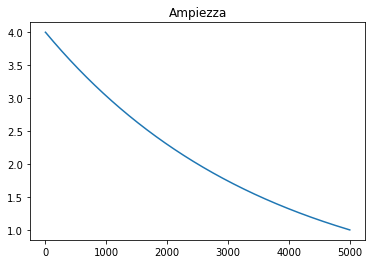

In [584]:
plt.plot(rad_values)
plt.title("Ampiezza")

Text(0.5, 1.0, 'Learning Rate')

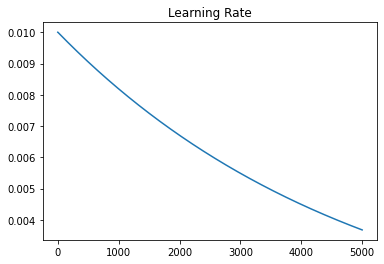

In [585]:
plt.plot(learn_rates_values)
plt.title("Learning Rate")

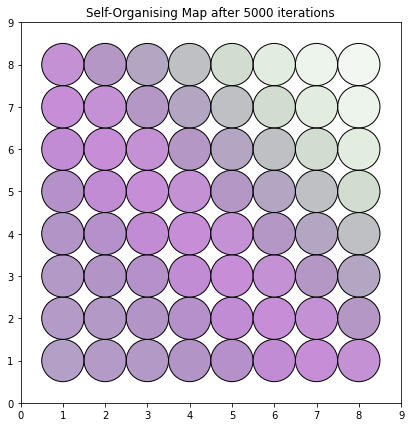

In [586]:
# Visuliza weight of the SOM after a number of epochs

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(1,1,1, aspect='equal')
ax.set_xlim((0, num_col+1))
ax.set_ylim((0, num_rows+1))
ax.set_title('Self-Organising Map after %d iterations' % epoch)

for x in range(1, num_col + 1):
    for y in range(1, num_rows + 1):
        ax.add_patch(patches.Circle((x, y), 0.5, facecolor=som_net[x-1,y-1,:], edgecolor='black'))
plt.show()

fig.savefig('SOM_iris_data.png')


In [587]:
u_matrix = np.zeros((num_col-1, num_rows-1)) #Calcolo la U-Matrix che mi permette di visualizzare la distanza tra i neuroni

for x in range(1, num_col):
    for y in range(1, num_rows):
        neighbour_list = list()
        print("-"* 100)
        print("neighbour cordinates of x=%d, y=%d" %(x,y))

        # Verifico la vicinanza tra i neuroni
        for u in range(x-1, x+2):
            if (u < 0 or u > (num_col-1)): #Esploro neurone per neurone
                continue
            for v in range(y-1, y+2):
                if(v < 0 or v > (num_rows-1)):
                    continue
                if (u == x and v == y):
                    break

                neighbour_list.append(np.array([u,v])) 
                print(u,v)
        
        #Calcolo la somma e media della distanza trai i pesi 
        sum=0
        for idx in neighbour_list:
            sum += calculate_euclidean_distance(som_net[x,y,:], som_net[idx[0],idx[1],:])
        
        avg = sum/len(neighbour_list)
        print("Sum of distance to neighbour weights=%f, average=%f" % (sum, avg))     
        u_matrix[x-1,y-1] = avg

----------------------------------------------------------------------------------------------------
neighbour cordinates of x=1, y=1
0 0
0 1
0 2
1 0
1 2
2 0
2 1
2 2
Sum of distance to neighbour weights=0.916219, average=0.114527
----------------------------------------------------------------------------------------------------
neighbour cordinates of x=1, y=2
0 1
0 2
0 3
1 1
1 3
2 1
2 2
2 3
Sum of distance to neighbour weights=1.359706, average=0.169963
----------------------------------------------------------------------------------------------------
neighbour cordinates of x=1, y=3
0 2
0 3
0 4
1 2
1 4
2 2
2 3
2 4
Sum of distance to neighbour weights=1.791485, average=0.223936
----------------------------------------------------------------------------------------------------
neighbour cordinates of x=1, y=4
0 3
0 4
0 5
1 3
1 5
2 3
2 4
2 5
Sum of distance to neighbour weights=1.432198, average=0.179025
--------------------------------------------------------------------------------

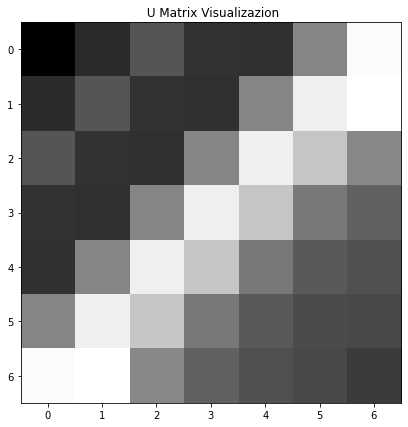

In [588]:
fig = plt.figure(figsize=(7,7))
plt.title (" U Matrix Visualizazion")
plt.imshow(u_matrix, cmap='gray')
plt.show()

fig.savefig('U_Matrix_iris.png')

##### Nell'immagine di sopra abbiamo che i gruppi di colore chiaro possono essere visti come cluster, mentre le parti scure come confini tra i vari cluster